In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import os
import collections
import re 
from imageio import imread, imwrite
from multiprocessing import Pool
import matplotlib.pyplot as plt
import cv2
import gdown
import math
#import matplotlib.pyplot as plt

In [5]:
## Open File and Extract FIDS
def extract_fids(load_location,saved_location):
    file = open(load_location, "r").read()
    file.split("FID:")
    occurences = [_.start() for _ in re.finditer("FID:", file)] 
    fids ={}
    for occ in occurences:
        key=file[occ-8:occ-2]
        value = file[occ+5:occ+10]
        fids[key]=value
    print(fids)
    with open(save_location, 'w') as fp:
        json.dump(fids, fp)

In [6]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG76859.linse10_output.out"
save_location = "../fids/fids_v3.3.json"
extract_fids(load_location,save_location)

{'005000': '260.4', '010000': '121.4', '015000': '59.09', '020000': '46.96', '025000': '39.55', '030000': '41.60', '035000': '36.66', '040000': '45.35', '045000': '47.94', '050000': '62.48', '055000': '75.63', '060000': '80.82', '065000': '114.7', '070000': '122.4', '075000': '156.6'}


In [4]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG76189.linse2_output.out"
save_location = "/usrhomes/g013/SemanticStyleGAN/fids/fids_v3_2.json"

extract_fids(load_location,save_location)

{'005000': '277.8', '010000': '161.1', '015000': '104.2', '020000': '79.95', '025000': '62.04', '030000': '57.06', '035000': '52.64', '040000': '50.96'}


## Extract Losses

In [7]:
def plot_loss_diff(iterations,g_losses,d_losses,save_location=None):
    d_losses= np.array(d_losses)
    g_losses=np.array(g_losses)
    diff= np.abs(g_losses-d_losses)
    x_keys = iterations
    rang= 20
    max_val = max(diff)
    min_val = min(diff)
    step= (max_val-min_val)/20

    plt.plot(x_keys,diff,c='y',label="loss difference")
    plt.yticks(np.arange(max_val,min_val,step))
    plt.xlabel("Iterations in Thousand")
    plt.ylabel("Loss Values")
    plt.xticks(rotation='vertical')
    plt.legend(loc="upper right")
    if save_location:
            location =Path(save_location)
            plt.savefig(str(location.parent/location.stem)+".png", bbox_inches='tight')
    else:
            plt.show()


In [8]:
def plot_losses(iterations,g_losses,d_losses,save_location=None):
    x_keys = iterations
    rang= 20
    max_val = max(max(g_losses),max(d_losses))
    min_val = min(min(g_losses),min(d_losses))
    step= (max_val-min_val)/20

    plt.plot(x_keys,g_losses,c='b',label="Generator loss")
    plt.plot(x_keys,d_losses,c='g',label="Discriminator loss")
    plt.yticks(np.arange(min_val,max_val,step))
    plt.xlabel("Iterations in Thousand")
    plt.ylabel("Loss Values")
    plt.xticks(rotation='vertical')
    plt.legend(loc="upper right")
    if save_location:
            location =Path(save_location)
            plt.savefig(str(location.parent/location.stem)+".png", bbox_inches='tight')
    else:
            plt.show()


In [9]:

def extract_losses(load_location):
    file = open(load_location, "r").read()
    file.split("\n")
    iterations=[]
    d_losses=[]
    g_losses=[]
    upper_bound=20
    ## Extract Data from CSV
    for line in file.split("\n"):
        if not ("d:" in line and "g:" in line):
            continue
        split_2 = line.split(" ")
        iteration = int(split_2[0][1:-1])
        discriminator_loss = float(split_2[2][:-1])
        generator_loss = float(split_2[4][:-1])
        if generator_loss > upper_bound or discriminator_loss>upper_bound:
            continue
        iterations.append(iteration)
        d_losses.append(discriminator_loss)
        g_losses.append(generator_loss)
    return(iterations,d_losses,g_losses)
def get_losses(load_location,save_location=None,difference=False):
    iterations,d_losses,g_losses=extract_losses(load_location)
    if difference:
        plot_loss_diff(iterations,g_losses,d_losses,save_location)
    else:
        plot_losses(iterations,g_losses,d_losses,save_location)


#occurences = [_.start() for _ in re.finditer("FID:", file)] 

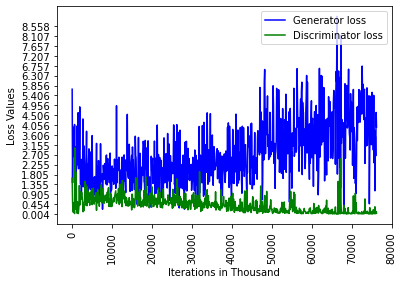

In [10]:
load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG76859.linse10_output.out"
save_location = "/usrhomes/g013/SemanticStyleGAN/fids/loss_diff.png"
get_losses(load_location,save_location,difference=False)


array([10.8277,  4.2683,  2.6898, ...,  3.8772,  5.9984,  7.9635])

In [18]:
g_losses

[12.0748,
 4.3315,
 2.8231,
 0.7477,
 4.066,
 4.869,
 3.1693,
 1.9894,
 2.9304,
 4.7342,
 1.6361,
 1.0532,
 2.9913,
 2.173,
 0.4847,
 2.462,
 1.7646,
 2.7353,
 2.5781,
 1.1169,
 1.7538,
 1.4568,
 1.9104,
 2.1562,
 2.0795,
 1.7475,
 0.6862,
 2.2158,
 1.4167,
 1.8113,
 2.1925,
 2.4026,
 3.1823,
 2.0829,
 3.0921,
 2.7217,
 1.8628,
 2.9406,
 0.8275,
 1.1786,
 1.9262,
 2.8205,
 2.1811,
 2.4865,
 2.0533,
 1.5963,
 2.5898,
 0.5421,
 2.58,
 1.6474,
 1.8133,
 0.7428,
 2.9422,
 0.363,
 2.0003,
 1.5996,
 2.8123,
 2.3805,
 0.9296,
 1.6326,
 1.7246,
 1.8809,
 2.0464,
 1.0086,
 1.7062,
 1.9446,
 2.4477,
 2.4625,
 0.7005,
 2.148,
 1.1316,
 2.92,
 2.0368,
 0.7501,
 3.1507,
 2.406,
 1.9371,
 2.3209,
 1.7777,
 1.7647,
 1.0815,
 1.1153,
 0.907,
 2.3737,
 2.8166,
 1.9217,
 1.3146,
 2.5524,
 3.6911,
 1.6183,
 3.8906,
 2.874,
 1.945,
 1.5872,
 2.4579,
 1.5057,
 1.7572,
 3.1394,
 2.1381,
 2.6827,
 1.5787,
 1.9555,
 2.5376,
 1.8124,
 2.6663,
 3.385,
 1.2051,
 1.8381,
 1.5796,
 1.9726,
 1.3368,
 0.721,
 0.7807

In [7]:
plot_losses(iterations,g_losses,d_losses)

NameError: name 'iterations' is not defined

In [12]:
np.divide(iterations,100)

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 2.247e+03, 2.248e+03,
       2.249e+03])

In [40]:
max(g_losses)

198.7304